In [360]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import reduce, partial
import scipy
from typing import Tuple
from importlib import reload
from cycler import cycler
from itertools import chain
# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 get_segments)


from writhe_tools.plots import (
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot,
                                build_matrix_boxplot_grid,
                                lineplot1D)

from writhe_tools.tcca import CCA, tCCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans, rotate_points, acf, pmf


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,                                 
                                   to_contacts
                                    )


from writhe_tools.utils import (lsdir,
                                group_by,
                                reindex_list,
                                contiguous_bool,
                                to_numpy,
                                num_str,
                                load_dict,
                                save_dict,
                                product
                                )


from typing import Dict, List, Tuple


import warnings
warnings.filterwarnings("ignore")



fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )



def fill_1d(x, values, indices):
    x[indices] = values
    return x

def fill(x, index, val):
    x[:, index] = val
    return x

def prod(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

ternary_bool = lambda distances : prod([to_contacts(i, 1).any(1) for i in split(distances)])

isin_index = lambda x, y : np.where(np.isin(x, y))[0]




def bootstrap(data: np.ndarray,
              confidence_level: float = 0.68,
              n_resamples: int = 500,
              lower_upper: bool = False,
              method: str = "percentile") -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=np.mean,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data) if data.ndim == 1 else data.mean(0)
    error = [res.confidence_interval.low, res.confidence_interval.high] if lower_upper\
            else (res.confidence_interval.high - res.confidence_interval.low) / 2
    if data.ndim > 1:error = np.stack(error)
    
    return mean, error





import numpy as np
import warnings



from pyblock.blocking import reblock, find_optimal_block
from collections import Counter

def block_error(x: np.ndarray, lower_upper: bool = False):
    """
    x : (N, d) numpy array with d features and N measurements
    """
    n = x.shape[0]
    blocks = reblock(x.T)
    optimal_indices = np.asarray(find_optimal_block(n, blocks))
    isnan = np.isnan(optimal_indices)
    #mode = Counter(optimal_indices[~isnan].astype(int)).most_common()[0][0]
    optimal_indices[isnan] = -1 # biggest block
    optimal_indices=optimal_indices.astype(int)
    #op
    #print(optimal_indices[0])
    if x.ndim == 1:
        return lu_from_error(x.mean(), blocks[optimal_indices[0]].std_err.item()) if lower_upper else\
                (x.mean(), blocks[optimal_indices[0]].std_err.item())
    else:
        return lu_from_error(x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))\
                if lower_upper else (x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))

def lu_from_error(mean, error):
    if all(isinstance(i, (float, int)) for i in (mean, error)):
        mean, error = [mean], [error]
    return mean, np.array([[mu - err, mu + err] for mu, err in zip(mean, error)]).T

# convenience (hard coded to 2 monomers) function to combine stats and prop error for averages to be taken over both monomers
def monomer_aggr_stats(x, 
                       error:callable=block_error, 
                       lower_upper: bool = False, 
                       fill_bool:np.ndarray=None):
    # compue mean and error over both monomers, aggregate, fill zeros for plotting, give lower, upper errors or absolute error
    ave, err = error(x, lower_upper=False)
    ave = np.add.reduce(split(x.mean(0))) / 2
    err = np.linalg.norm(err.reshape(2, -1), axis=0) / 2
    
    if lower_upper:
        # very simple error propogation here (arguably too simple)
        err = lu_from_error(ave, err)[-1]                   
        if fill_bool is not None:
            ave = fill_1d(np.zeros(len(fill_bool)), ave, fill_bool)
            err = np.stack([fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in err])

        return ave, err


    return (ave, err) if fill_bool is None else [fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in [ave, err]]


#block_error(np.arange(10000), lower_upper=False)
path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
helix_pdb = '/data/r1r2/monomer_r1r2_helix.pdb'

trunc = .3
pre_trunc = .3
state_width = .8
state_font_scale = 1.5
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]


In [390]:
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'dejavusans'   # or 'cm', 'custom', etc.
plt.rcParams['font.family'] = 'DejaVu Sans'       # default Matplotlib font


# proton density with explicit code 

In [366]:
def get_non_exchangeable_protons(traj):
    """
    Return indices of all hydrogen atoms bound to carbon atoms (non-exchangeable protons)
    in a given MDTraj trajectory or topology.

    Parameters:
    -----------
    traj : md.Trajectory or md.Topology

    Returns:
    --------
    List of atom indices (integers)
    """
    # Get topology
    top = traj.topology if isinstance(traj, md.Trajectory) else traj

    non_exchangeable = []

    for atom in top.atoms:
        if atom.element.symbol == 'H':
            # Iterate over all bonds in the topology
            for bond in top.bonds:
                a1, a2 = bond
                if atom in bond:
                    other = a2 if atom == a1 else a1
                    if other.element.symbol == 'C':
                        non_exchangeable.append(atom.index)
                    break  # Done once we find its bond
    return np.array(non_exchangeable, dtype=int)


from copy import deepcopy
from copy import deepcopy
pdb = md.load(protein_pdb)
sequence, ca_index = get_residues(pdb)
resnames = sequence[ca_index]
non_exchangeable = get_non_exchangeable_protons(pdb)

# now work on the non-exchange-able hydrogen version of the trajectory
# note that indices will now be changed - some linkers don't have any such hydrogens
# so, new indices must be generated
trajH = pdb.atom_slice(non_exchangeable)
residuesH = get_residues(trajH)[0]
residue_index = np.where(np.isin(residuesH, resnames))[0]
monomer_h_indices = [trajH.top.select(' or '.join([f'resid {i}' for i in j])) for j in np.array_split(residue_index, 2)]

# now must prep specific targets for each coordination number
targets = [np.array_split(np.array([trajH.top.select(f'resid {i} and name HD1')
           for i in np.array([i for i, j in enumerate(residuesH) if 'TRP' in j])]), 2),
           np.array_split(np.concatenate([trajH.top.select(f'resid {i} and (name HD1 or name HD2)' if 'TYR' in residuesH[i] else
                                                  f'resid {i} and name HZ3') for i in np.array([i for i, j in enumerate(residuesH) if ('TRP' in j) or ('TYR' in j)])]), 2),
           np.array_split(np.array([trajH.top.select(f'resid {i} and (name HE1 or name HE2)') for i in np.array([i for i, j in enumerate(residuesH) if 'TYR' in j])]), 2)]
    
targets = [list(map(np.ndarray.flatten, i)) for i in targets]


# assume: pdb, trajH, residuesH, monomer_h_indices, targets already defined

all_noe_contacts, all_noe_errors = [], []

# loop over each target group (e.g., HD1 for TRP, HD1/2+HZ3 combo, HE1/2 for TYR)
for target_set in targets:

    noe_contacts = []
    noe_errors = []

    # iterate over all trajectory files for this specific target group
    for file in protein_files:
        traj = md.load(file,
                       top=protein_pdb,
                       atom_indices=non_exchangeable,
                       stride=1)

        # target_set already contains two flattened arrays (for each monomer)
        distance_pairs = [product(i, j) for i, j in zip(target_set, monomer_h_indices[::-1])]

        total_contacts = np.stack([
            to_contacts(md.compute_distances(traj, pair), 0.6)
            for pair in distance_pairs
        ]).sum(-1)

        # identical normalization and statistics as in your reference code
        noe_contacts.append(total_contacts.mean(-1) / len(target_set[0]))
        noe_errors.append(block_error(total_contacts.T)[-1] / len(target_set[0]))

    # store per-target-group results
    all_noe_contacts.append(deepcopy(noe_contacts))
    all_noe_errors.append(deepcopy(noe_errors))


# proton density

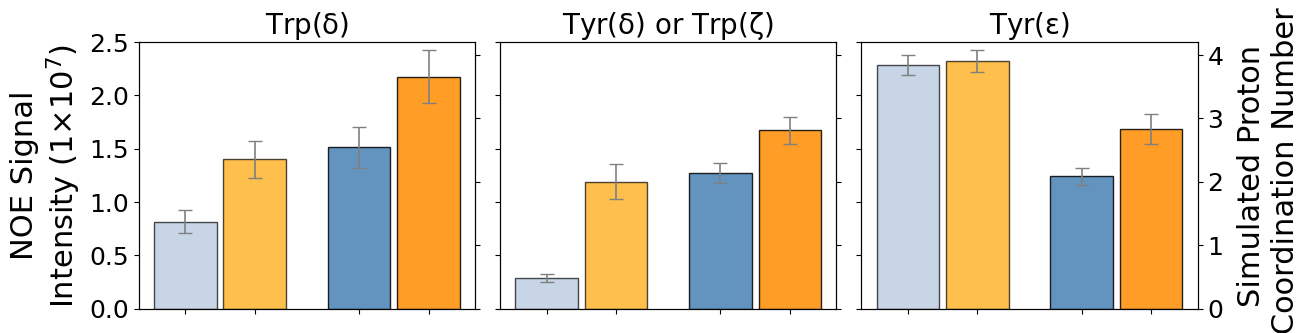

In [391]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

all_noe_contacts = np.stack(all_noe_contacts)
all_noe_errors = np.stack(all_noe_errors)


merged_groups = {
    r"Trp($\delta$)": {
        "sim_vals": [all_noe_contacts[0][0].mean(), all_noe_contacts[0][1].mean()],
        "sim_err":  [np.linalg.norm(all_noe_errors[0][0]) / 2, np.linalg.norm(all_noe_errors[0][1]) / 2],
        "exp_vals": [8.13e6, 1.40e7],
        "exp_err":  [1.084295e6, 1.752398e6]
    },
    r"Tyr($\delta$) or Trp($\zeta$)": {
        "sim_vals": [all_noe_contacts[1][0].mean(), all_noe_contacts[1][1].mean()],
        "sim_err":  [np.linalg.norm(all_noe_errors[1][0]) / 2, np.linalg.norm(all_noe_errors[1][1]) / 2],
        "exp_vals": [2.86e6, 1.19e7],
        "exp_err":  [4.084170e5, 1.632425e6]
    },
    r"Tyr($\varepsilon$)": {
        "sim_vals": [all_noe_contacts[2][0].mean(), all_noe_contacts[2][1].mean()],
        "sim_err":  [np.linalg.norm(all_noe_errors[2][0]) / 2, np.linalg.norm(all_noe_errors[2][1]) / 2],
        "exp_vals": [2.2875602e7, 2.3239409e7],
        "exp_err":  [9.531501e5, 9.995445e5]
    }
}


colors_exp = ["lightsteelblue", "orange"]
colors_sim = ["steelblue", "darkorange"]
labels_all = ["Apo", "EPI-002", "Apo", "EPI-002"]

# Bar positions (gap between experimental and simulation)
x_exp = np.array([-0.3, -0.1])
x_sim = np.array([0.2, 0.4])

fig, axes = plt.subplots(1, 3, figsize=(13.2, 3.9), sharey=False)
plt.rcParams["text.usetex"] = False

for i, (title, data) in enumerate(merged_groups.items()):
    ax1 = axes[i]  # Experimental axis
    ax2 = ax1.twinx()  # Simulated axis

    # Experimental bars
    bar1=ax1.bar(x_exp, data["exp_vals"], width=0.18, color=colors_exp,
            yerr=data["exp_err"], capsize=5, ecolor='gray',edgecolor='black', error_kw={'elinewidth': 1.2},alpha=.7,)
    ax1.set_ylim(0, 2.5e7)
    ax1.ticklabel_format(style='plain')
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False, useOffset=False))
    ax1.yaxis.offsetText.set_visible(False)
    if i == 0:
        ax1.set_ylabel("NOE Signal\n" + r"Intensity (1$\times$10$^7$)", fontsize=22, color='black')
        ax1.tick_params(axis='y', labelsize=14, labelcolor='black')
    else:
        ax1.set_ylabel("")
        ax1.set_yticklabels([])

    # Simulated bars with error bars
    bar2=ax2.bar(x_sim, data["sim_vals"], width=0.18, color=colors_sim, alpha=.85,
            yerr=data["sim_err"], capsize=5, ecolor='gray',edgecolor='black', error_kw={'elinewidth': 1.2})
    #for b in bar2:b.set_hatch('//')
    ax2.set_ylim(0, 4.2)
    if i == 2:
        ax2.set_ylabel("Simulated Proton\n Coordination Number", fontsize=22, color='black', labelpad=10)
        #ax2.tick_params(axis='y', labelsize=14, labelcolor='black')
    else:
        ax2.set_ylabel("")
        ax2.set_yticklabels([])

    #bar2[0].set_hatch('//')
        

    # X-axis setup
    ax1.set_xticks(np.concatenate([x_exp, x_sim]))
    ax1.set_xticklabels([])
    ax1.set_title(title, fontsize=20)

    ax2.tick_params('both', labelsize=18)
    ax1.tick_params('both', labelsize=18)

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in colors_exp + colors_sim]
# fig.legend(handles, labels_all, loc="upper center", ncol=4, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.88])

# Dimer stability and analysis

In [397]:
dimers = [np.load(i) for i in reindex_list(lsdir('./long_events/', exclude='lengths'), [1,2,0])] # this is just the events
average_dimer=[bootstrap(.24 * np.fromiter(map(len, contiguous_bool(bools=i)), float), lower_upper=False) for i in dimers]  # scale by physical time
acfs = [acf(i)[:8000] for i in dimers]

box_plot(np.fromiter((i[0] for i in average_dimer), float),
         errors=np.array([i[1] for i in average_dimer]).T,
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['indianred','steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=2, 
         labels=labels,
         title = 'Mean Dimer Lifetimes',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=0.8,figsize=(5, 2.5))




In [395]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

def multi_exp(x, *params, pcov=None, return_error=False,
              prediction_variance=False, s2=None):
    """
    Sum of exponentials with optional covariance-based uncertainty propagation.

    Parameters
    ----------
    x : array_like
        Independent variable(s).
    *params : float
        Parameters [a1, tau1, a2, tau2, ...].
    pcov : (m, m) array, optional
        Covariance matrix of the fitted parameters (from curve_fit).
        Must already include the residual variance scaling (as curve_fit does).
    return_error : bool, default=False
        If True and pcov is given, returns (y, sigma_y).
    prediction_variance : bool, default=False
        If True, include the residual variance term (s2) when computing
        propagated uncertainty (i.e., return the *prediction* variance).
        If False, return the *mean-curve* (confidence) variance only.
    s2 : float, optional
        Residual variance. Required if prediction_variance=True and
        you want to include noise explicitly. If None and prediction_variance=True,
        s2 is estimated as the average diagonal of pcov scaling (safe fallback).

    Returns
    -------
    y : ndarray
        Model values at x.
    sigma_y : ndarray, optional
        1σ propagated uncertainty at each x (confidence or prediction band).
    """
    x = np.asarray(x, dtype=float)
    params = np.asarray(params, dtype=float)
    n = len(params) // 2
    a = params[0::2]
    tau = params[1::2]

    # Model evaluation
    exp_terms = np.exp(-x[:, None] / tau[None, :])      # (N, n)
    y = np.sum(a[None, :] * exp_terms, axis=1)          # (N,)

    if not (return_error and pcov is not None):
        return y

    # Analytical Jacobian: shape (N, 2n)
    N = x.size
    J = np.empty((N, 2*n), dtype=float)

    # ∂y/∂a_i = e^{-x/τ_i}
    J[:, 0::2] = exp_terms

    # ∂y/∂τ_i = a_i * (x/τ_i^2) * e^{-x/τ_i}
    x_over_tau2 = x[:, None] / (tau[None, :]**2)
    J[:, 1::2] = (a[None, :] * x_over_tau2) * exp_terms

    # Propagate covariance: Var(y) = J Cov J^T
    var_y = np.einsum("ij,jk,ik->i", J, pcov, J, optimize=True)

    # Optional: include residual variance for prediction interval
    if prediction_variance:
        if s2 is None:
            # Safe fallback: use scalar estimate from pcov trace / param count
            s2 = np.mean(np.diag(pcov)) / np.mean(np.diag((pcov / np.diag(pcov))**0))
            # Simpler fallback if the above ever fails numerically:
            s2 = np.mean(np.diag(pcov)) if not np.isfinite(s2) else s2
        var_y += s2

    sigma_y = np.sqrt(np.maximum(var_y, 0.0))
    return y, sigma_y



def fit_multi_exp(x, y, n_exp=2, p0=None, bounds=(0, np.inf), alpha=0.05, verbose=True):
    """
    Fit n_exp exponentials to data (x, y) and print a detailed summary.

    Returns
    -------
    results : dict of all fitted parameters, errors, and diagnostics.
    """
    x, y = np.asarray(x), np.asarray(y)

    # Crude initial guess if none provided
    if p0 is None:
        A_guess = np.linspace(y.max(), y.max() / n_exp, n_exp)
        T_guess = np.linspace((x.max() - x.min()) / (2*n_exp), x.max()/n_exp, n_exp)
        p0 = np.ravel(np.column_stack([A_guess, T_guess]))

    popt, pcov = curve_fit(lambda x, *p: multi_exp(x, *p), x, y, p0=p0, bounds=bounds)

    # Model, residuals, and stats
    y_fit = multi_exp(x, *popt)
    residuals = y - y_fit
    n, p = len(y), len(popt)
    dof = max(1, n - p)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    rmse = np.sqrt(ss_res / dof)
    perr = np.sqrt(np.diag(pcov))

    # Confidence intervals
    t_crit = stats.t.ppf(1 - alpha/2, dof)
    ci_lower = popt - t_crit * perr
    ci_upper = popt + t_crit * perr

    # Relative (%) errors
    rel_err = np.abs(100 * perr / popt)

    # --- Pretty summary printout ---
    if verbose:
        print("="*78)
        print(f"EXPONENTIAL FIT SUMMARY  (n_exp = {n_exp})")
        print("="*78)
        print(f"Data points (n): {n:<8d}  Degrees of freedom: {dof:<8d}")
        print(f"Residual SS: {ss_res:.6g}    Total SS: {ss_tot:.6g}")
        print(f"R² = {r2:.6f}    RMSE = {rmse:.6g}\n")

        print(f"{'Parameter':<8} {'Value':>14} {'±1σ':>14} {'RelErr %':>10} "
              f"{'95% CI lower':>16} {'95% CI upper':>16}")
        print("-"*78)

        for i in range(n_exp):
            ai, taui = 2*i, 2*i + 1
            print(f"a{i+1:<2} {'':<3}{popt[ai]:>14.6g} {perr[ai]:>14.6g} "
                  f"{rel_err[ai]:>10.3f} {ci_lower[ai]:>16.6g} {ci_upper[ai]:>16.6g}")
            print(f"τ{i+1:<2} {'':<3}{popt[taui]:>14.6g} {perr[taui]:>14.6g} "
                  f"{rel_err[taui]:>10.3f} {ci_lower[taui]:>16.6g} {ci_upper[taui]:>16.6g}")
            print("-"*78)
        print("\n")

    return {
        "popt": popt,
        "pcov": pcov,
        "perr": perr,
        "rel_err": rel_err,
        "ci": (ci_lower, ci_upper),
        "residuals": residuals,
        "ss_res": ss_res,
        "ss_tot": ss_tot,
        "r2": r2,
        "rmse": rmse,
        "dof": dof,
        "n": n
    }

fits = [fit_multi_exp(np.arange(8000) * 0.24, i[:8000]) for i in acfs]

EXPONENTIAL FIT SUMMARY  (n_exp = 2)
Data points (n): 8000      Degrees of freedom: 7996    
Residual SS: 1.19028    Total SS: 185.522
R² = 0.993584    RMSE = 0.0122008

Parameter          Value            ±1σ   RelErr %     95% CI lower     95% CI upper
------------------------------------------------------------------------------
a1           0.419164     0.00170284      0.406         0.415826         0.422502
τ1            56.0496       0.447736      0.799          55.1719          56.9273
------------------------------------------------------------------------------
a2           0.458033     0.00107505      0.235         0.455925          0.46014
τ2            588.643        1.38895      0.236           585.92          591.366
------------------------------------------------------------------------------


EXPONENTIAL FIT SUMMARY  (n_exp = 2)
Data points (n): 8000      Degrees of freedom: 7996    
Residual SS: 2.62305    Total SS: 116.885
R² = 0.977559    RMSE = 0.018112

Parameter

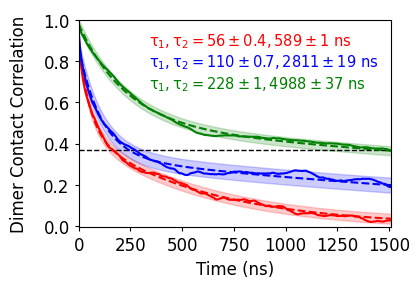

In [396]:
fig, ax = plt.subplots(1, 1, figsize=(4.3, 3))

ax.axhline(y=1/np.exp(1),
           linestyle='--',
           color='black',
           linewidth=1,
           #label='1/e',
          )

colors = ['red', 'blue', 'green']
labels = ['APO', 'EPI-002', '1aa']

for i, (ac, color, label) in enumerate(zip(acfs, colors, labels)):
    yhat, y_err = multi_exp(
        0.24 * np.arange(8000),
        *fits[i]['popt'],
        pcov=fits[i]['pcov'],
        s2=fits[i]['ss_res'] / fits[i]['dof'],
        prediction_variance=True,
        return_error=True,
    )

    # fitted curve + confidence band
    lineplot1D(
        yhat,
        0.24 * np.arange(8000),
        y1=yhat - 2 * y_err,
        y2=yhat + 2 * y_err,
        fill_alpha=.2,
        ax=ax,
        label_stride=250,
        color=color,
        fill_color=color,
        ls='--'
    )

    # empirical ACF (dashed)
    lineplot1D(
        ac[:8000],
        0.24 * np.arange(8000),
        fill_alpha=1,
        ax=ax,
        label_stride=241,
        color=color,
        ls='-',
        ylabel_rotation=90,
        label = label,
        
    )

ax.set_xlim(0, 1510)

# ---------- annotation block (top-right) ----------
x_text = 0.985
y_top = 1.05
line_spacing = 0.105

# leave blank space for manual equation
ax.text(
    x_text, y_top, " ",  # intentional blank
    color='black',
    fontsize=11,
    transform=ax.transAxes,
    ha='right', va='top'
)

# --- improved numeric formatting ---
def fmt_value(x: float) -> str:
    """Format numeric value:
    - ≥1  → integer
    - <1  → one significant figure
    """
    if x >= 1.0:
        return str(int(np.round(x)))
    # compute one significant figure manually
    if x == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    rounded = round(x, -exp)  # round to 1 sig fig
    # format cleanly, no trailing zeros
    return np.format_float_positional(rounded, trim='-')

#τ lines
for i, (label, color, fit) in enumerate(zip(labels, colors, fits)):
    popt = np.array(fit['popt'], dtype=float)
    perr = np.sqrt(np.diag(fit['pcov']))

    taus = popt[1::2]
    tau_errs = perr[1::2]

    tau_syms = ", ".join([rf"\tau_{{{j+1}}}" for j in range(len(taus))])

    tau_vals = []
    for tau, err in zip(taus, tau_errs):
        tau_disp = fmt_value(float(tau))
        err_disp = fmt_value(float(err))
        tau_vals.append(rf"{tau_disp}\pm{err_disp}")
    tau_vals = ", ".join(tau_vals)

    #text_line = rf"{label}: ${tau_syms} = {tau_vals}\ \mathrm{{ns}}$"
    text_line = rf"${tau_syms} = {tau_vals}\ \mathrm{{ns}}$"


    ax.text(
        x_text-.76,
        y_top - (i + 1) * line_spacing,
        text_line,
        color=color,
        fontsize=10.5,
        transform=ax.transAxes,
        ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.65, pad=1.5)
    )
ax.set_ylabel('Dimer Contact Correlation', )
ax.set_xlabel('Time (ns)')
plt.tight_layout()
ax.set_xticks([0, 250, 500, 750, 1000, 1250, 1500], [0, 250, 500, 750, 1000, 1250, 1500])
#ax.legend(bbox_to_anchor=[1,1])
fig.savefig('./binding_curves.png', dpi=1000, bbox_inches='tight')